# Visão Computacional - PUCPR

# Trabalho 3 visão computacional
## PJBL3 - CNN - Simpsons Classification
Allan Braun
Bruna Lima Farias
Matheus Bertho

# Materiais e métodos

Dataset:

Utilizado o mesmo dataset do trabalho anterior, este consta imagens que se classificam entre: bart, family, homer, lisa, maggie e marge.
Foram removidas as imagens da classe family por orientação do professor.
Essa base foi dividida entre 80% para treinamento e 20% para validação
Além disso todas as imagens foram flipadas com o intuíto de aumentar o tamanho do dataset e prover mais insformações para a rede.
(Data Augmentation)

Modelo:
Como modelo irá ser utilizada CNN com 5 layers e outra do estado da arte através da biblioteca tensorflow

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, \
                            confusion_matrix, \
                            ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, losses

2022-11-18 23:22:14.751314: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-18 23:22:14.751365: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [22]:
# configurações seeds e warnings
seed_number = 42
tf.random.set_seed(seed_number)
np.random.seed(seed_number)

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import warnings
warnings.filterwarnings('ignore')

In [4]:
# função utilitária para desempenho das redes neurais

def plot_history(history, figsize=(8,4)):
    fig, ax = plt.subplots(1,2, figsize=figsize)

    for i, field in enumerate(['acc', 'loss']):
        ax[i].plot(history.history[field])
        ax[i].plot(history.history[f'val_{field}'])
        ax[i].set_title(f'model {field}')
        ax[i].set_ylabel(field)
        ax[i].set_xlabel('epoch')
        ax[i].legend(['train', 'val'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

## Separação dos dados

In [26]:
# informações dos dados

dataset = 'simpsons'
batch_size_ = 32
input_shape_ = (315, 390, 3)
class_names = ['bart', 'homer', 'lisa', 'maggie', 'marge']
num_classes = len(class_names)

In [27]:
# carregando as imagens do diretório

X_train, X_val = tf.keras.utils.image_dataset_from_directory(
    f'./simpsons/',
    seed=seed_number,
    subset='both',
    validation_split=.2,
    image_size=(input_shape_[0], input_shape_[1]),
    batch_size=batch_size_
)

Found 321 files belonging to 5 classes.
Using 257 files for training.
Using 64 files for validation.


In [28]:
y_train = tf.concat([y for x, y in X_train], axis=0)
y_val = tf.concat([y for x, y in X_val], axis=0)

y_train.shape, y_val.shape

(TensorShape([257]), TensorShape([64]))

# 2) Experimentos

## Rede CNN com 5 camadas
Abaixo foi construida uma rede neural CNN com 5 camadas.

In [23]:
# criando a arquitetura da rede

model = models.Sequential()

# Uma camada de pré-processamento que redimensiona os valores de entrada para um novo intervalo.
model.add(layers.Rescaling(1./255, input_shape=input_shape_))

# Keras Conv2D é uma Camada de Convolução 2D, esta camada cria um kernel de convolução que é enrolado com entrada de camadas que ajuda a produzir um tensor de saídas.
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2))) # camada de pooling
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# A Flatten nivela os tensores de entrada multidimensionais em uma única dimensão
model.add(layers.Flatten())
# Neurônios na camada densa obtêm sua fonte de dados de entrada de todos os outros neurônios da camada anterior da rede.
# A função relu retorna 0 se receber qualquer entrada negativa, mas para qualquer valor positivo x ela retorna esse valor
model.add(layers.Dense(128, activation='relu'))
# função de regreção logistica
model.add(layers.Dense(num_classes,activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 315, 390, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 313, 388, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 156, 194, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 154, 192, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 77, 96, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 75, 94, 64)       

In [ ]:
# compilação e treinamento

epochs_ = 20

model.compile(
    optimizer='Adam',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

history = model.fit(
    X_train,
    batch_size=batch_size_,
    epochs=epochs_,
    validation_data=X_val
)

In [ ]:
plot_history(history)

In [ ]:
print('reasultado do evaluate =', model.evaluate(X_val, verbose=0))

y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)
cm_plot = ConfusionMatrixDisplay(cm, display_labels=class_names)
cm_plot.plot(cmap='viridis_r');

## Rede CNN de 5 camadas com dropout e Data Augmentation

In [29]:
# data augmentation: criando imagens sintéticas a partir
# das imagens originais flipando elas horizontalmente

data_augmentation_layer = tf.keras.Sequential([
    layers.RandomFlip('horizontal', input_shape=input_shape_),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

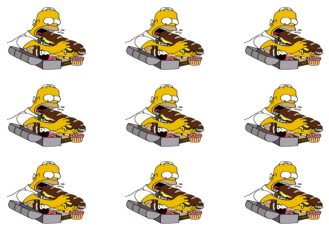

In [30]:
# mostrando disferentes layers de uma imagem utilizando o data_augmentation
for images, _ in X_train.take(1):
    for i in range(9):
        augmented_images = data_augmentation_layer(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')

In [14]:
# rede cnn com data augmentation e dropout com o intúito de reduzir a possibilidade da rede se tornar viciada

model = tf.keras.Sequential([
    data_augmentation_layer,  
    layers.Rescaling(1./255, input_shape=(96, 96, 3)),

    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),  
    layers.Dropout(0.2),
    layers.Flatten(),
    
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [15]:
# compilação e treinamento

model.compile(
    optimizer='Adam',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

history = model.fit(
    X_train,
    batch_size=batch_size_,
    epochs=epochs_,
    validation_data=X_val
)

Epoch 1/20
11/11 [==============================] - 64s 5s/step - loss: 7.8186 - acc: 0.3214 - val_loss: 1.4670 - val_acc: 0.4217
Epoch 2/20
11/11 [==============================] - 58s 5s/step - loss: 1.3765 - acc: 0.3839 - val_loss: 1.2357 - val_acc: 0.5663
Epoch 3/20
11/11 [==============================] - 58s 5s/step - loss: 1.1893 - acc: 0.4762 - val_loss: 1.3007 - val_acc: 0.4699
Epoch 4/20
11/11 [==============================] - 58s 5s/step - loss: 1.0659 - acc: 0.5446 - val_loss: 1.2985 - val_acc: 0.5542
Epoch 5/20
11/11 [==============================] - 61s 6s/step - loss: 0.9340 - acc: 0.5655 - val_loss: 1.4349 - val_acc: 0.5904
Epoch 6/20
11/11 [==============================] - 66s 6s/step - loss: 0.8893 - acc: 0.5863 - val_loss: 1.4153 - val_acc: 0.5904
Epoch 7/20
11/11 [==============================] - 67s 6s/step - loss: 0.8105 - acc: 0.6161 - val_loss: 1.3890 - val_acc: 0.5783
Epoch 8/20
11/11 [==============================] - 64s 6s/step - loss: 0.8451 - acc: 0.63

In [ ]:
plot_history(history)

In [ ]:
# resultados e matriz de confusão

print('resultado do evaluate =', model.evaluate(X_val, verbose=0))

y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)
cm_plot = ConfusionMatrixDisplay(cm, display_labels=class_names)
cm_plot.plot(cmap='viridis_r');

## Rede ResNet50 e Transfer Learning

Foi utilizada a rede ResNet50 para realizar um Transfer Learning, isto é, transferir o aprendizado de uma rede para outra tarefa. Foram treinadas somente as últimas camadas da rede com as imagens dos simpsons, e a ideia é comparar com as outras técnicas e arquiteturas utilizadas.

In [18]:
# resnet50
conv_layers =  tf.keras.applications.resnet50.ResNet50(
    weights=None,
    include_top=False,
    input_tensor=tf.keras.layers.Input(input_shape_),
    classes=num_classes
)

conv_layers.trainable = True

# conv layers
model = tf.keras.Sequential([  
  conv_layers,    
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 10, 13, 2048)      23587712  
                                                                 
 flatten_2 (Flatten)         (None, 266240)            0         
                                                                 
 dense_4 (Dense)             (None, 128)               34078848  
                                                                 
 dense_5 (Dense)             (None, 5)                 645       
                                                                 
Total params: 57,667,205
Trainable params: 57,614,085
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
# compilação e treinamento
# são feitas em 10 épocas devido ao custo computacional

epochs_ = 10

model.compile(
    optimizer='Adam',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

history = model.fit(
    X_train,
    batch_size=batch_size_,
    epochs=epochs_,
    validation_data=X_val)

In [ ]:
plot_history(history)

In [ ]:
print('resultado do evaluate =', model.evaluate(X_val, verbose=0))

y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)
cm_plot = ConfusionMatrixDisplay(cm, display_labels=class_names)
cm_plot.plot(cmap='viridis_r');

# Discussão Crítica

**As redes neurais foram melhores que os modelos clássicos de ML? (PBL2)**

Foi observado desempenho superior em relação aos modelos clássicos Os modelos de CNN conseguem resultados muito mais precisos, evidenciando sua facilidade em trabalhar com imagens. 
Sendo que também a rede neural se destaca pela facilidade, e o tabalho manual de se aplicar filtros é nulo comparado aos modelos classicos.

**A utilização de dropout e data augmentation foi eficaz?**

Sim, ao utilizarmos as técnicas observamos melhoras de até 10% em relação ao uso da rede inicial.
Principais motivos são que essas técnicas diminuem o "vício" da rede neural nas imagens, e possibilitam que classes desbalancedas tenham mais relevancia na rede.

**A utilização do Transfer Learning foi eficaz?**

Não, no exemplo deste trabalho, concluímos que para o Transfer Learning ser eficaz, diminuindo o tempo de treinamento. 